# Лабораторная работа №4

_Выполнили: Гуревич Михаил и Трохан Александр, M32001_


## Подготовка


In [25]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from tqdm.notebook import tqdm


def is_singular(matrix: np.ndarray):
    return np.linalg.det(matrix) == 0

## Реализация алгоритмов


### Метод Гаусса с выбором ведущего элемента


In [26]:
def solve_Gauss(A: np.ndarray, b: np.ndarray):
    if is_singular(A):
        raise ValueError("Matrix is singular")
    A = np.c_[A, b]  # присоединяем столбец b к матрице A
    
    n = A.shape[0]

    for k in tqdm(range(n)):
        pivot = k + np.argmax(abs(A[k:, k]))
        if pivot != k:
            A[k], A[pivot] = A[pivot], np.copy(A[k])
        current_row = A[k]
        A[k] /= current_row[k]
        for lower_row in A[k + 1:]:
            lower_row -= lower_row[k] * current_row

    for k in tqdm(range(n - 1, 0, -1)):
        for upper_row in A[:k]:
            upper_row[-1] -= upper_row[k] * A[k, -1]
            upper_row[k] = 0
            
    return A[:, -1]

### Метод LU-разложения

Помимо самого метода в задании требуется хранить разреженные матрицы с помощью сжатого хранения строкой (Compressed Sparse Row, CSR). Для этого реализуем класс `CSRMatrix`:


In [5]:
class CSRMatrix:
    def __init__(self, data, indices, indptr, shape):
        self.data = data
        self.indices = indices
        self.indptr = indptr
        self.shape = shape

    @staticmethod
    def from_dense(matrix: np.ndarray):
        data = []
        indices = []
        indptr = [0]
        for row in matrix:
            for i, elem in enumerate(row):
                if elem != 0:
                    data.append(elem)
                    indices.append(i)
            indptr.append(len(data))
        return CSRMatrix(data, indices, indptr, matrix.shape)

    def to_dense(self):
        matrix = np.zeros(self.shape)
        for i in range(self.shape[0]):
            for j in range(self.indptr[i], self.indptr[i + 1]):
                matrix[i, self.indices[j]] = self.data[j]
        return matrix
    
    def get_arrays(self):
        return self.data, self.indices, self.indptr, self.shape

Сам метод LU-разложения и решение системы с него:

In [35]:
def LU_decomposition(matrix: CSRMatrix):
    matrix = matrix.to_dense()
    n = matrix.shape[0]
    L = np.eye(n)
    U = np.zeros((n, n))
    for i in tqdm(range(n)):
        for j in range(n):
            if j >= i:
                U[i, j] = matrix[i, j] - sum(L[i, k] * U[k, j] for k in range(i))
            else:
                L[i, j] = (matrix[i, j] - sum(L[i, k] * U[k, j] for k in range(j))) / U[j, j]

    return L, U

def solve_LU(A: np.ndarray, b: np.ndarray):
    if is_singular(A):
        raise ValueError("Matrix is singular")

    L, U = LU_decomposition(CSRMatrix.from_dense(A))
    n = A.shape[0]
    y = np.zeros(n)
    for i in tqdm(range(n)):
        y[i] = b[i] - sum(L[i, j] * y[j] for j in range(i))

    x = np.zeros(n)
    for i in tqdm(range(n - 1, -1, -1)):
        x[i] = (y[i] - sum(U[i, j] * x[j] for j in range(i + 1, n))) / U[i, i]
    return x

### Метод Зейделя


In [42]:
def solve_Seidel(A: np.ndarray, b: np.ndarray, epsilon=1e-6, max_iterations=1e6):
    n = A.shape[0]
    x = np.zeros(n)
    x_new = np.zeros(n)
    for _ in range(int(max_iterations)):
        for i in range(n):
            x_new[i] = b[i] - sum(A[i, j] * x_new[j] for j in range(i)) - sum(A[i, j] * x[j] for j in range(i + 1, n))
            x_new[i] /= A[i, i]
        if np.linalg.norm(x_new - x) < epsilon:
            break
        x = np.copy(x_new)
    else:
        print("Max iterations exceeded")

    return x_new

## Исследование методов

In [8]:
def generate_b(matrix: np.ndarray):
    n = matrix.shape[0]
    return matrix @ np.array(np.arange(1, n + 1, 1), dtype=np.float64)

### Матрицы с диагональным преобладанием

Генерация матриц

In [9]:
def generate_diag(n, k):
    matrix = np.array([[np.random.randint(-4, 1) for _ in range(n)] for _ in range(n)], dtype=float)

    for i in range(n):
        if i == 0:
            matrix[i, i] = -sum(matrix[i, j] for j in range(n) if j != i) + 10. ** float(-k)
        else:
            matrix[i, i] = -sum(matrix[i, j] for j in range(n) if j != i)

    return matrix

Зависимость числа обусловленности от k

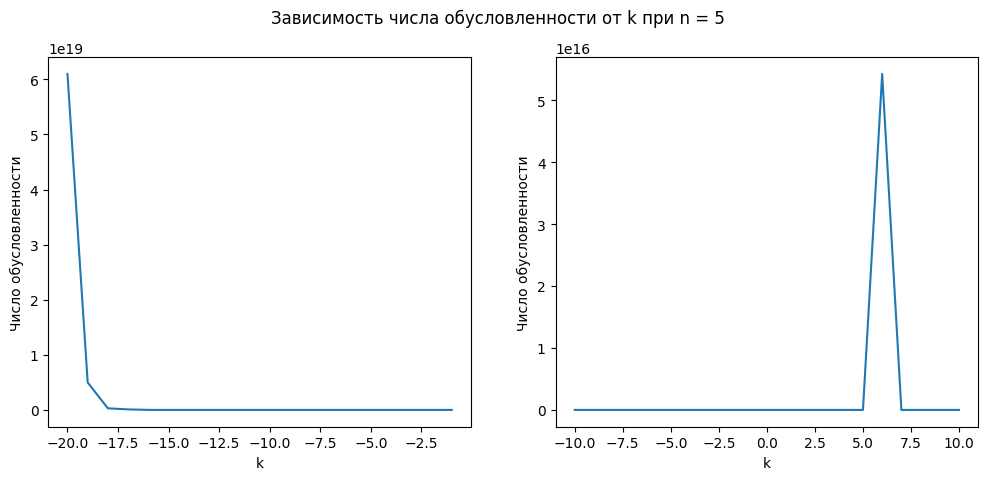

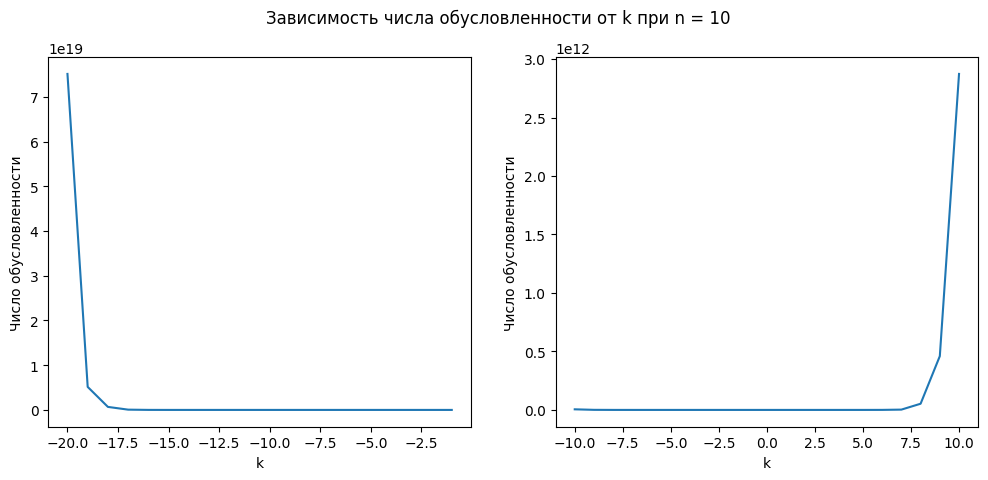

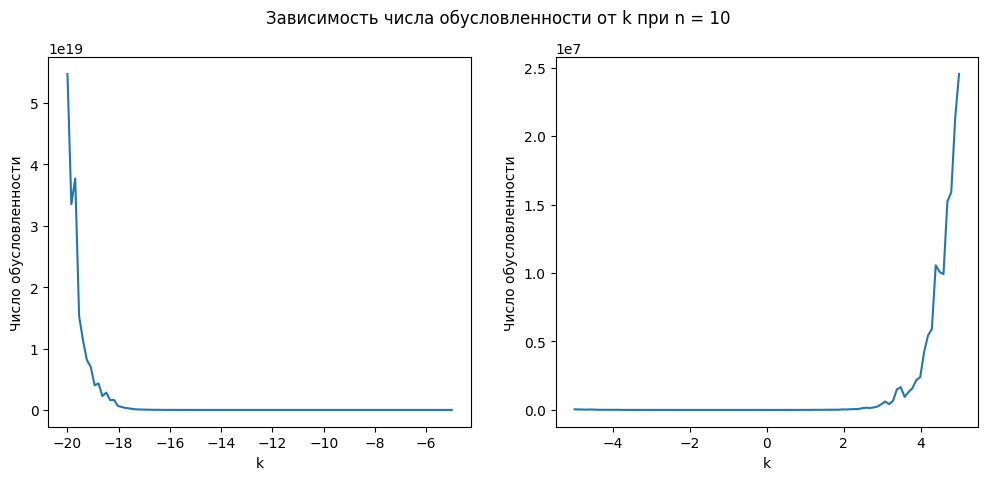

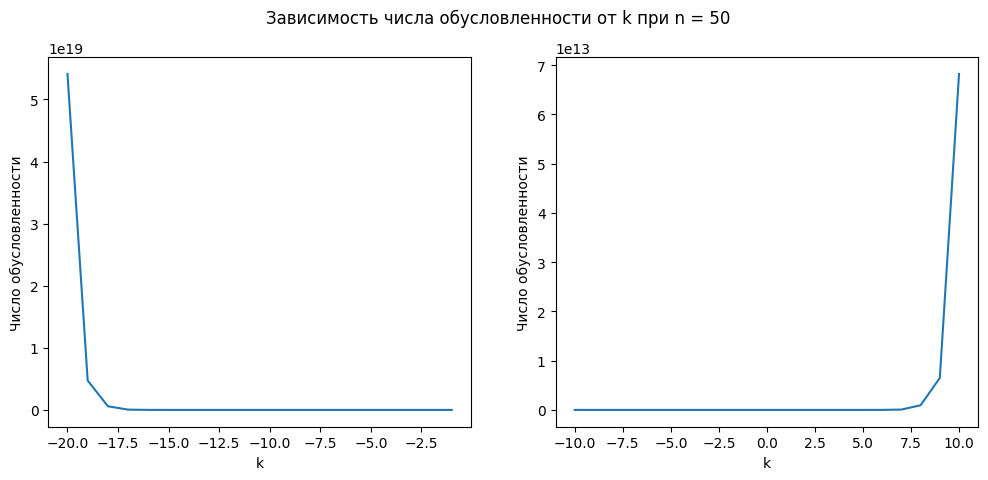

In [10]:
def plot_condition_number_graph(n, k_array_large=np.ndarray, k_array_small=np.ndarray):
    condition_numbers_large = []
    condition_numbers_small = []

    for k in k_array_small:
        matrix = generate_diag(n, k)
        condition_numbers_small.append(np.linalg.cond(matrix))

    for k in k_array_large:
        matrix = generate_diag(n, k)
        condition_numbers_large.append(np.linalg.cond(matrix))

    fig = plt.figure()

    ax1 = fig.add_subplot(121)
    ax1.plot(k_array_small, condition_numbers_small)
    ax1.set_xlabel("k")
    ax1.set_ylabel("Число обусловленности")

    ax2 = fig.add_subplot(122)
    ax2.plot(k_array_large, condition_numbers_large)
    ax2.set_xlabel("k")
    ax2.set_ylabel("Число обусловленности")

    fig.suptitle(f"Зависимость числа обусловленности от k при n = {n}")
    fig.set_figwidth(12)
    plt.show()

plot_condition_number_graph(5, np.arange(-10, 11), np.arange(-20, 0))
plot_condition_number_graph(10, np.arange(-10, 11), np.arange(-20, 0))
plot_condition_number_graph(10, np.linspace(-5, 5, 100), np.linspace(-20, -5, 100))
plot_condition_number_graph(50, np.arange(-10, 11), np.arange(-20, 0))

/Users/michael/Library/Python/3.9/lib/python/site-packages/mpl_toolkits/mplot3d/proj3d.py:124: RuntimeWarning: invalid value encountered in divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


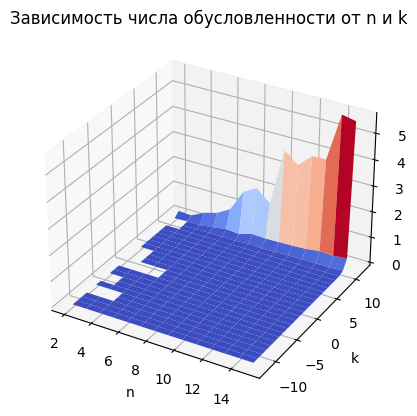

In [11]:
n = np.arange(2, 16)
k = np.arange(-12, 13)
N, K = np.meshgrid(n, k)
Z = np.zeros(N.shape)

for i in range(N.shape[0]):
    for j in range(N.shape[1]):
        matrix = generate_diag(N[i, j], K[i, j])
        Z[i, j] = np.linalg.cond(matrix)
        
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(N, K, Z, cmap=cm.coolwarm)
ax.set_xlabel("n")
ax.set_ylabel("k")
ax.set_title("Зависимость числа обусловленности от n и k")
plt.show()


Зависимость точности от k

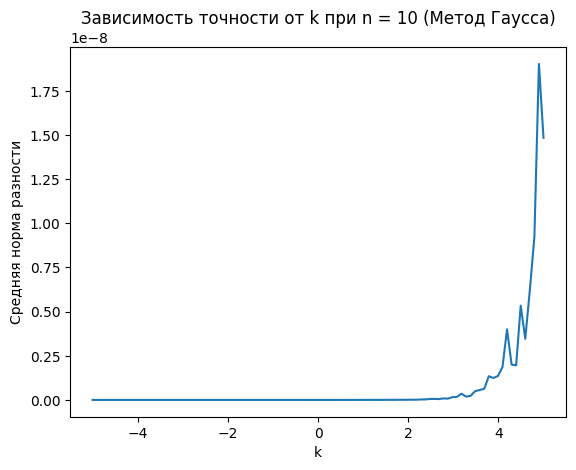

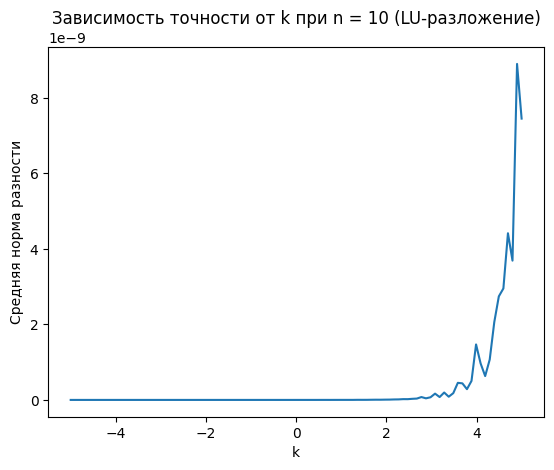

In [12]:
def plot_solution_graph(n, k_array: np.ndarray, method, method_name, iterations=10):
    real = np.array([i for i in range(1, n + 1)])
    result = []

    for k in k_array:
        solutions = []
        for _ in range(iterations):  # для усреднения
            A = generate_diag(n, k)
            while is_singular(A):
                A = generate_diag(n, k)
            b = generate_b(A)
            solutions.append(np.linalg.norm(real - method(A, b)))
        result.append(np.mean(solutions))

    plt.plot(k_array, result)
    plt.xlabel("k")
    plt.ylabel("Средняя норма разности")
    plt.title(f"Зависимость точности от k при n = {n} ({method_name})")
    plt.show()
        
plot_solution_graph(10, np.linspace(-5, 5, 100), solve_Gauss, "Метод Гаусса")
plot_solution_graph(10, np.linspace(-5, 5, 100), solve_LU, "LU-разложение")

In [13]:
plot_solution_graph(10, np.linspace(-5, 5, 100), solve_Seidel, "Метод Зейделя", iterations=2)

Max iterations exceeded
Max iterations exceeded
Max iterations exceeded
Max iterations exceeded
Max iterations exceeded


KeyboardInterrupt: 

### Матрицы Гильберта

Генерация матриц

In [14]:
def generate_Hilbert(n):
    return np.array([[1 / (i + j + 1) for j in range(n)] for i in range(n)], dtype=float)

Зависимость числа обусловленности от n

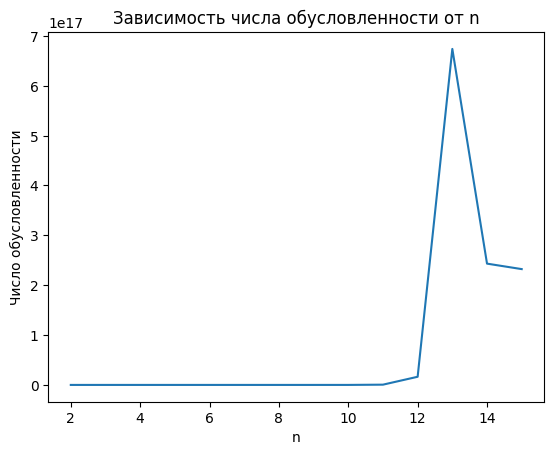

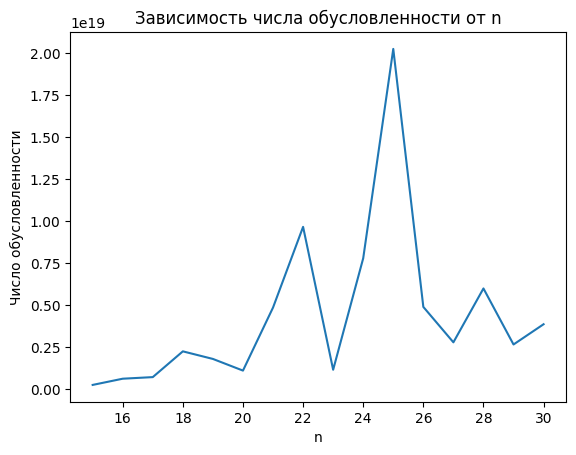

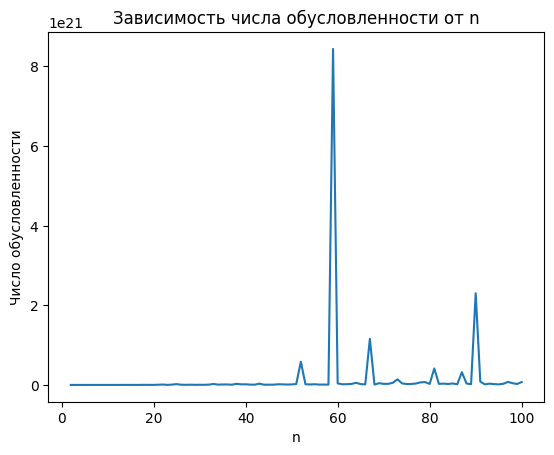

In [ ]:
def plot_condition_number_graph_Hilbert(n_array: np.ndarray):
    condition_numbers = []

    for n in n_array:
        condition_numbers.append(np.linalg.cond(generate_Hilbert(n)))
    
    plt.plot(n_array, condition_numbers)
    plt.xlabel("n")
    plt.ylabel("Число обусловленности")
    plt.title("Зависимость числа обусловленности от n")
    plt.show()

plot_condition_number_graph_Hilbert(np.arange(2, 16))
plot_condition_number_graph_Hilbert(np.arange(15, 31))
plot_condition_number_graph_Hilbert(np.arange(2, 101))


Зависимость точности от n

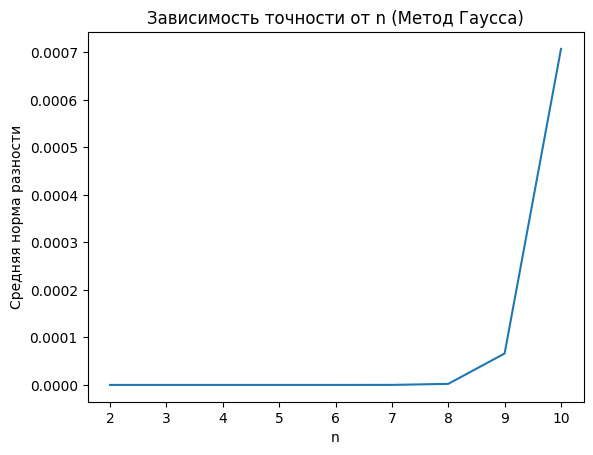

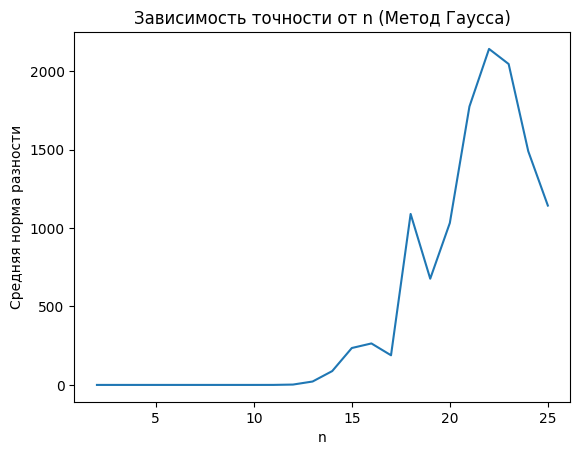

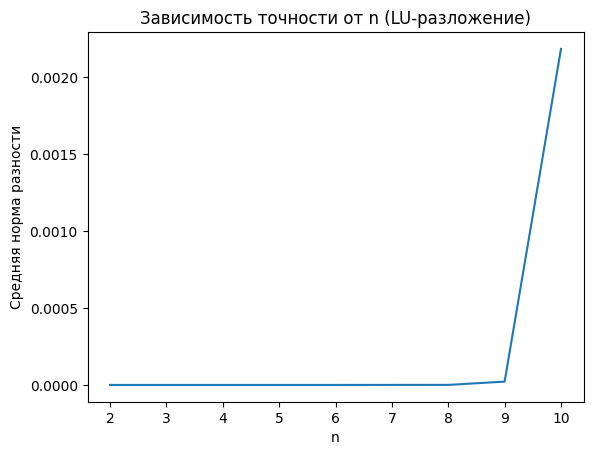

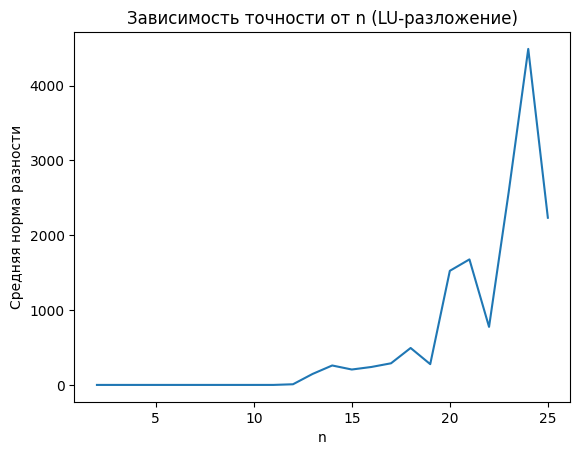

In [ ]:
def plot_solution_graph_Hilbert(n_array: np.ndarray, method, method_name, iterations=10):
    result = []

    for n in n_array:
        real = np.array([i for i in range(1, n + 1)])
        solutions = []
        for _ in range(iterations):
            A = generate_Hilbert(n)
            b = generate_b(A)
            solutions.append(np.linalg.norm(real - method(A, b)))
        result.append(np.mean(solutions))

    plt.plot(n_array, result)
    plt.xlabel("n")
    plt.ylabel("Средняя норма разности")
    plt.title(f"Зависимость точности от n ({method_name})")
    plt.show()

plot_solution_graph_Hilbert(np.arange(2, 11), solve_Gauss, "Метод Гаусса")
plot_solution_graph_Hilbert(np.arange(2, 26), solve_Gauss, "Метод Гаусса")
plot_solution_graph_Hilbert(np.arange(2, 11), solve_LU, "LU-разложение")
plot_solution_graph_Hilbert(np.arange(2, 26), solve_LU, "LU-разложение")

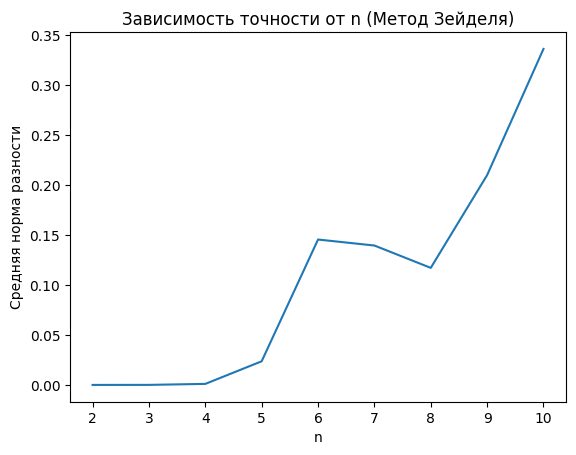

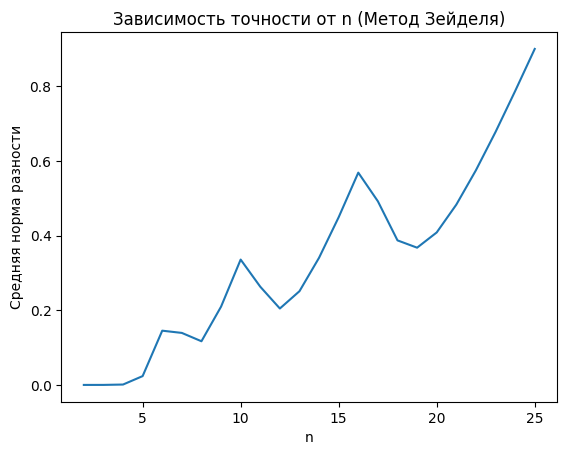

In [ ]:
plot_solution_graph_Hilbert(np.arange(2, 11), solve_Seidel, "Метод Зейделя", iterations=1)
plot_solution_graph_Hilbert(np.arange(2, 26), solve_Seidel, "Метод Зейделя", iterations=1)

## Сравнение эффективности методов в зависимости от размера матрицы n

In [15]:
n = np.array([10, 50, 1e2, 1e3, 1e4], dtype=int)
matrises = [generate_diag(i, 0) for i in n]

Метод Гаусса:

In [33]:
from datetime import datetime

np.warnings.filterwarnings("ignore")

for i in tqdm(range(len(n))):
    print("Processing n = ", n[i], "...", sep="")
    start = datetime.now()
    solve_Gauss(matrises[i], generate_b(matrises[i]))
    end = datetime.now()
    print(f"n = {n[i]}, time = {end - start}")

  0%|          | 0/5 [00:00<?, ?it/s]

Processing n = 10...


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

n = 10, time = 0:00:00.019866
Processing n = 50...


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

n = 50, time = 0:00:00.021442
Processing n = 100...


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

n = 100, time = 0:00:00.072784
Processing n = 1000...


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/999 [00:00<?, ?it/s]

n = 1000, time = 0:00:01.100277
Processing n = 10000...


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9999 [00:00<?, ?it/s]

n = 10000, time = 0:05:25.641090


Метод LU-разложения:

In [37]:
for i in tqdm(range(len(n))):
    print("Processing n = ", n[i], "...", sep="")
    start = datetime.now()
    solve_LU(matrises[i], generate_b(matrises[i]))
    end = datetime.now()
    print(f"n = {n[i]}, time = {end - start}")

  0%|          | 0/5 [00:00<?, ?it/s]

Processing n = 10...


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

n = 10, time = 0:00:00.033025
Processing n = 50...


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

n = 50, time = 0:00:00.045181
Processing n = 100...


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

n = 100, time = 0:00:00.255069
Processing n = 1000...


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

n = 1000, time = 0:01:08.702649
Processing n = 10000...


  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

Метод Зейделя:

In [44]:
for i in tqdm(range(len(n))):
    print("Processing n = ", n[i], "...", sep="")
    start = datetime.now()
    solve_Seidel(matrises[i], generate_b(matrises[i]), max_iterations=1e10)
    end = datetime.now()
    print(f"n = {n[i]}, time = {end - start}")

  0%|          | 0/5 [00:00<?, ?it/s]

Processing n = 10...
n = 10, time = 0:00:00.027862
Processing n = 50...
n = 50, time = 0:00:10.997308
Processing n = 100...
n = 100, time = 0:03:11.563388
Processing n = 1000...


KeyboardInterrupt: 